<div align="center">
    <h1>UW Madison GI Tract Image Segmentation : Data Preparation from Scratch</h1>
    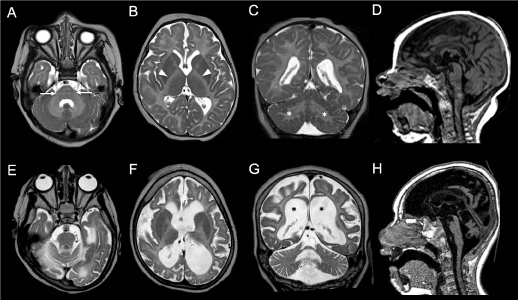
</div>

This notebooks hold all the steps to prepare the appropriate dataset from scratch and will be used for future notebooks i.e. on training, inferencing.

# Import Libraries:

In [ ]:
# Libraries
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize

In [ ]:
# CONSTANTS
SEED  = 42
BATCH_SIZE = 64
import warnings
warnings.filterwarnings("ignore")

# Defining paths :
As only the training dataset has to be made in this notebook, so only defining the training paths.

In [ ]:
train_dir = "../input/uw-madison-gi-tract-image-segmentation/train"
training_metadata_path = "../input/uw-madison-gi-tract-image-segmentation/train.csv"

# Loading Metadata and Preprocessing :
Now, we have to load the metadata and process the primary findings.

### Loading metadata :

In [ ]:
# loading metadata
train_df = pd.read_csv(training_metadata_path)
train_df.head()

In [ ]:
# viewing primary information 
train_df.info()

We can see most of the record doesen't have any segmentation, so we can say that there's no segmentation.

### Preprocessing :

First step is to extract the primary case ids. Also we have to make the segmentation masks into string format as the nan values will be difficult to etract in other ways.

In [ ]:
train_df["segmentation"] = train_df["segmentation"].astype("str")
train_df["case_id"] = train_df["id"].apply(lambda x: x.split("_")[0][4:])
train_df["day_id"] = train_df["id"].apply(lambda x: x.split("_")[1][3:])
train_df["slice_id"] = train_df["id"].apply(lambda x: x.split("_")[-1])

Let's visualize the dataset again.

In [ ]:
train_df.head()

Now, we have to extract the paths from the image ids.

In [ ]:
def fetch_file_from_id(root_dir, case_id):
    case_folder = case_id.split("_")[0]
    day_folder = "_".join(case_id.split("_")[:2])
    file_starter = "_".join(case_id.split("_")[2:])
    # fetching folder paths
    folder = os.path.join(root_dir, case_folder, day_folder, "scans")
    # fetching filenames with similar pattern
    file = glob(f"{folder}/{file_starter}*")
    # returning the first file, though it will always hold one file.
    return file[0]
train_df["path"] = train_df["id"].apply(lambda x: fetch_file_from_id(train_dir, x))
train_df.head()

Now, from the file paths we have to extract the heght and width of the image as well as the mask. Also there are some other attributes, leaving them just for simplicity.

In [ ]:
train_df["height"] = train_df["path"].apply(lambda x: os.path.split(x)[-1].split("_")[2]).astype("int")
train_df["width"] = train_df["path"].apply(lambda x: os.path.split(x)[-1].split("_")[3]).astype("int")
train_df.head()

Now, let's see how many classes are present here.

In [ ]:
train_df["class"].unique()

We have to use the class as the channel in the mask, so performing label encoding.

In [ ]:
class_names = train_df["class"].unique()
for index, label in enumerate(class_names):
    # replacing class names with indexes
    train_df["class"].replace(label, index, inplace = True)
train_df.head()

# Mask Generation Methodology : 

The Segmentation mask given in this place are in **RLE (RUN LENGTH ENCODING)** format.

#### At first we have to understand how the format is :

1. We can consider the given data has a particular shape , let's say height is **H** and width is **W**.
2. Now we can consider the data in a flattened manner i.e. shape of the data is **(batch_size, H*W)**.
3. The mask values are seperated by a space where every pair of value holds the valid infomation.
4. The first value of the pair holds the sarting index of the mask in the flattened grid.
5. The second value of the pair holds the length of mask from that starter pixel.
6. So basically we can say , every element in the odd position holds the starter index and rest holds the length of the presence of the mask.

#### Now , to process the mask what we can do :

1. Split the odd elements and he even ones into different array which correspond length of present mask pixels and starter indexes.
2. Add all the indexes that must be masked.
3. Reshape the flattened array to image grid.

Adding utility functions to process mask and images

In [ ]:
def prepare_mask_data(string):
    # fetching all the values from the string
    all_values = map(int, string.split(" "))
    # preparing the usable arrays
    starterIndex, pixelCount = [], []
    for index, value in enumerate(all_values):
        if index % 2:
            # storing even indexed values in pixelCount
            pixelCount.append(value)
        else:
            # storing odd indexed values in starterIndex
            starterIndex.append(value)
    return starterIndex, pixelCount
    
def fetch_pos_pixel_indexes(indexes, counts):
    final_arr = []
    for index, counts in zip(indexes, counts):
        # adding all the values from starterIndex to range of positive pixel counts
        final_arr += [index + i for i in range(counts)]
    return final_arr

def prepare_mask(string, height, width):
    # preparing the respective arrays
    indexes, counts = prepare_mask_data(string)
    # preparing all the pixel indexes those have mask values
    pos_pixel_indexes = fetch_pos_pixel_indexes(indexes, counts)
    # forming the flattened array
    mask_array = np.zeros(height * width)
    # updating values in the array
    mask_array[pos_pixel_indexes] = 1
    # reshaping the masks
    return mask_array.reshape(height, width)

def load_image(path):
    # loading the image in RGB format
    image = Image.open(path).convert('RGB')
    return image

# Dataset preparation : 

Now, we have to prepare the custom dataset  inherited from pytorch's Datatset class.

In [ ]:
class UWDataset(Dataset):
    
    def __init__(self, meta_df, h=256, w=256):
        super().__init__()
        self.meta_df = meta_df
        self.h = h
        self.w = w
        self.resize = Resize((h, w))
        
    def __len__(self):
        return len(self.meta_df)
    
    def __getitem__(self, index):
        # fetching image path
        path = self.meta_df.loc[index, "path"]
        # loading image
        image = load_image(path)
        # loading mask's original height, width
        mask_h, mask_w = self.meta_df.loc[index, "height"], self.meta_df.loc[index, "width"]
        # loading the segmentation encoding for maks preparation
        mask_string = self.meta_df.loc[index, "segmentation"]
        # laoding the mask
        main_mask_channel = self.load_mask(string=mask_string, h=mask_h, w=mask_w)
        # updating those in tensor format
        image = ToTensor()(self.resize(image))
        main_mask_channel = ToTensor()(self.resize(main_mask_channel))
        # loading the original mask
        mask = torch.zeros((3, self.h, self.w))
        # loading the class label
        class_label = self.meta_df.loc[index, "class"]
        mask[class_label, ...] = main_mask_channel
        
        return image, mask
    
    def load_mask(self, string, h, w):
        # cheking if the segmentation encoding is a valid mask or null values
        if string != "nan":
            return Image.fromarray(prepare_mask(string, h, w))
        return Image.fromarray(np.zeros((h, w)))

#### Let's load the dataset

In [ ]:
ds = UWDataset(train_df)
print(f"Length of the dataset : {len(ds)}")

Let's check if the mask and the image are generating in a right way

In [ ]:
image, mask = ds[194]
image.shape, mask.shape

In [ ]:
combined_im_mask = torch.cat([image, mask], dim=2)

In [ ]:
def show_image(tensor_image, name):
    plt.figure(figsize=(20, 20))
    plt.imshow(tensor_image.permute(1,2,0))
    plt.title(name, size=30)
    plt.show()
show_image(combined_im_mask, "Real & Mask")

### Train Validation Split :
After creating the dataset it is time to split the data into training and validation.
We'll be using a **80-20 train-validation** split.

In [ ]:
train_size = int(len(ds)*0.8)
val_size = len(ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, val_size], generator=torch.Generator().manual_seed(42))
print(f"Length of the training dataset : {len(train_ds)}")
print(f"Length of the validation dataset : {len(val_ds)}")

Now as we have prepared all the data , it is time to prepared batched data that'll be feeded to the model for training purposes.

In [ ]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle = True, drop_last = True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last = True)

Let's visualize the first patch of training and validation patch

In [ ]:
for train_image_batch, train_mask_batch in train_dl:
    break
for val_image_batch, val_mask_batch in val_dl:
    break

In [ ]:
train_batch = torch.cat([make_grid(train_image_batch, nrow=8), make_grid(train_mask_batch, nrow=8)], dim=2)
val_batch = torch.cat([make_grid(val_image_batch, nrow=8), make_grid(val_mask_batch, nrow=8)], dim=2)

In [ ]:
show_image(train_batch, "Training Batch")

In [ ]:
show_image(val_batch, "Validation Batch")

Thus we conclude the data preparation step. 
Summary :
In this notebook we learnt :
1. how to process the data shapes form the image ids.
2. Process mask from RLE format.
3. Create custom dataset and dataloader for training purpose.


# If you liked the work, please UPVOTE :)

Do follow me on [**LinkedIn**](https://linkedin.com/in/sagnik1511) , [**GitHub**](https://github.com/sagnik1511) and on [**Kaggle**](https://kaggle.com/sagnik1511)

# Thanks for visiting :D
